In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import myML
import networkx as nx

In [2]:
def func(x):
    y = np.sin(x)+np.sin(2*x)+np.sin(5*x)
    return y

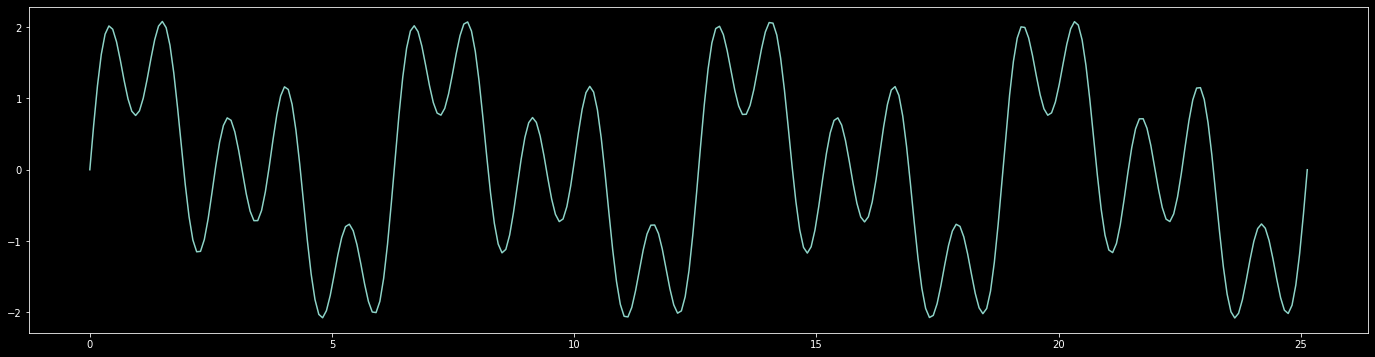

In [4]:
halfwavenumber = 8
wavesize = 20
timestep = np.pi/2/wavesize
t = np.array([np.linspace(0,np.pi*halfwavenumber,halfwavenumber*2*wavesize)])
y = func(t)
plt.style.use('dark_background')
fig = plt.figure(figsize=(24,6))
ax = plt.axes()
ax.plot(t[0,:],y[0,:])
plt.show()

In [315]:
def neuralplot(nodes, condition, W, A):
    g = nx.Graph()

    L = len(nodes)
    nmax = max(nodes)
    nodesize = 3000/nmax
    dic = {
        'pos' : {},
        'labels' : {},
        'weights' : [],
        'colors' : []
    }
    for l in range(L):
        for j in range(nodes[l]):
            nindex = (l+1)*100+j+1                                  #Neuron index
            g.add_node(nindex)

            y = ((nodes[l]-1)/2-j)                                  #Fixed position
            if nmax>11: y =  y*nmax/nodes[l]
            x = (l+1)
            dic['pos'][nindex] = (x,y)
            dic['labels'][nindex] = nindex-100

            if l>0:                                                 #Synapses
                for k in range(nodes[l-1]):
                    nindexprev = l*100+k+1
                    g.add_edge(nindexprev, nindex)

    for j in range(nodes[0]):                                       #Input labels
        nindex = 100+j+1
        dic['labels'][nindex] = 'Input '+str(j+1)
    for j in range(nodes[L-1]):                                     #Output labels
        nindex = 100*L+j+1
        dic['labels'][nindex] = 'Output '+str(j+1)

    absmax = 1
    for l in range(L):
        absmax = max(absmax, np.max(np.absolute(A[l])))

    if condition==True:
        param = nodesize
        nodesize = []
        for l in range(1,L):
            maxm = np.max(np.absolute(W[l]))
            minm = np.min(np.absolute(W[l]))
            for j in range(nodes[l]):
                nindex = (l+1)*100+j+1
                for k in range(nodes[l-1]):
                    value = (abs(A[l][j][0]*W[l][j,k]/absmax)-minm)/(maxm-minm)
                    dic['weights'].append(value*4+1)
                    if A[l][j][0]*W[l][j,k]>0:
                        dic['colors'].append((0, value*0.8+0.2, 0.2))
                    elif A[l][j][0]*W[l][j,k]<0:
                        dic['colors'].append((value*0.8+0.2, 0, 0.2))
                    else:
                        dic['colors'].append((0.1, 0.1, 0.1))
        for l in range(L):
            maxm = np.max(np.absolute(A[l]))
            minm = np.min(np.absolute(A[l]))
            for j in range(nodes[l]):
                nindex = (l+1)*100+j+1
                dic['labels'][nindex] = "{:.3f}".format(A[l][j][0])
                value = (abs(A[l][j][0])-minm)/(maxm-minm)
                if 1==nodes[l]: value=1
                nodesize.append(value*0.7*param+0.5*param)
                    

    nx.draw(g, dic['pos'], labels=dic['labels'], with_labels=True, node_size=nodesize, font_size=3)
    
    if condition==True: nx.draw_networkx_edges(g,dic['pos'], width=dic['weights'], edge_color=dic['colors'])

    aux = nx.Graph()                                                #Figure vertical size fix
    aux.add_node('Aux1')
    aux.add_node('Aux2')
    posaux = {}
    posaux['Aux1'], posaux['Aux2'] = [(0.9,nmax/2), (L+0.1,-nmax/2)]
    nx.draw(aux, posaux, node_size=0)

    plt.savefig('neuralplot/img{:05d}'.format(i), dpi=200)
    plt.clf()
    return

In [5]:
def tanh(x):
    return np.tanh(x)
def d_tanh(x):
    return 1-np.square(np.tanh(x))
def MSE(y,a):                                           #Mean squared error  --> Regression without outliers
    m = y.shape[1]
    return 2/m*(y-a)**2
def d_MSE(y,a):
    m = y.shape[1]
    return -1/m*(y-a)
def linear(x):                                          #Only used usually as output layer activation function
    return x
def d_linear(x):
    return np.sign(x)

def sigmoid(x):
    return 1/(1 + np.exp(-x))
def d_sigmoid(x):
    return (1 - sigmoid(x)) * sigmoid(x)

def ReLU(x):
    return np.maximum(0,x)
def d_ReLU(x):
    temp = np.sign(x)
    return np.maximum(0,temp)

class Layer:
    activationFunctions = {
        'tanh': (tanh, d_tanh),
        'sigmoid': (sigmoid, d_sigmoid),
        'ReLU': (ReLU, d_ReLU),
        'linear': (linear, d_linear)
    }

    def __init__(self, inputs, neurons, activationF):                   #Number of inputs, neurons & type of activation function
        self.w = np.random.randn(neurons, inputs) * np.sqrt(2./inputs)  #Initial weights
        self.b = np.zeros((neurons, 1))                                 #Initial biases
        self.act, self.d_act = self.activationFunctions.get(activationF)

    def feedforward(self, x):
        self.x = x                                                      #Input from the previous layer
        self.m = x.shape[1]                                             #Size of the batch
        self.z = self.w @ self.x + self.b @ np.ones((1, self.m))        #Inputs times weights plus biases
        self.y = self.act(self.z)                                       #Output from the current layer
        return self.y
    
    def backprop(self, dJdy, learning_rate, lambd):
        dJdz = np.multiply(dJdy, self.d_act(self.z))                    #dJdyl+1 * g'l = dJdz
        dJdw = dJdz @ self.x.T                                          #dJdz * al-1 = dJdw
        dJdb = dJdz @ np.ones((1, self.m)).T                            #dJdz * 1 = dJdb
        dJdx = self.w.T @ dJdz                                          #Information for the next layer

        reg = lambd/self.m*self.w                                       #Regularization term, only applied to the weights
        dJdw += reg

        self.w -= learning_rate * dJdw
        self.b -= learning_rate * dJdb
            
        return dJdx

In [36]:
#Feed Forward Neural Network ([list with nodes per layer], [list with the name of the desired activation function in each non-input layer], [loss function name])
#@test (X[d,m])
#@testwithplot (X[d,m], numberoftestingsamples=1 (always, this is a failsafe), [list with nodes per layer])
#@train (X[dx,m], Y[dy,m], nºepochs, type of optimizer, learning rate, regularization term)
class simpleRNN:
    lossfunctions = {
        'MSE': (MSE, d_MSE)
    }

    def __init__(self, pastlength, activation, lossname):
        self.pl = pastlength
        nodes = [self.pl, self.pl, 1]
        self.state = np.zeros((self.pl, 1))

        self.nlayers = len(activation)
        if self.nlayers != 2: print('Number of hidden layers must be one, 3 in total')
        self.layers = [None]*self.nlayers                               #Layer creation
        for i in range(self.nlayers):
            self.layers[i] = Layer(nodes[i],nodes[i+1],activation[i])
        self.loss, self.d_loss = self.lossfunctions.get(lossname)

    def forwardprop(self, x):
        for layer in self.layers:
            x = layer.feedforward(x)
        return x

    def advanceintime(self):
        y = self.forwardprop(self.state)
        for elem in reversed(range(1,self.pl)): self.state[elem,0] = self.state[elem-1,0]
        self.state[0,0] = y[0,0]
        return y[0,0]

    def advanceintimeplot(self):
        l = 0
        A = {}
        temp = self.state*1
        for layer in self.layers:
            A[l] = temp
            l += 1
            temp = layer.feedforward(temp)
        A[l] = temp


        W = {}
        for l in range(self.nlayers):
            W[l+1] = self.layers[l].w
        neuralplot([self.pl, self.pl, 1], True, W, A)

        for elem in reversed(range(1,self.pl)): self.state[elem,0] = self.state[elem-1,0]
        self.state[0,0] = temp[0,0]
        return temp[0,0]

    def resetstate(self, y_train):
        k = 0
        for i in reversed(range(y_train.shape[1])):
            self.state[k,0] = y_train[0,i]
            k+=1
            if k==self.pl: break
        return
    
    def backprop_learn(self, y_train, y, lr, lambd):
        dJdy = self.d_loss(y_train, y)
        for layer in reversed(self.layers):
            dJdy = layer.backprop(dJdy, lr, lambd)
        return
    
    def train(self, t, y_train, lr):
        costs = []
        tt = [y_train[0,0]]
        #In the first pass, we iterate through every timestep to obtain an acceptable initial condition
        numsteps = t.shape[1]
        self.state[0,0] = y_train[0,0]
        for step in range(1, numsteps):
            y = self.forwardprop(self.state)
            self.backprop_learn(np.array([y_train[:,step]]), y, lr, lambd = 0)
            J = np.sum(self.loss(np.array([y_train[:,step]]), y))
            costs.append(J)
            tt.append(y[0,0])
            for elem in reversed(range(1,self.pl)): self.state[elem,0] = self.state[elem-1,0]
            self.state[0,0] = y_train[0,step]

        #Then we do the same but only update the weights at the end
        self.resetstate(y_train[:,0:self.pl])
        temp = np.zeros((self.pl, numsteps-self.pl))
        for step in range(numsteps-self.pl):
            temp[:,step] = self.state[:,0]
            for elem in reversed(range(1,self.pl)): self.state[elem,0] = self.state[elem-1,0]
            self.state[0,0] = y_train[0,step+self.pl]

        for k in range(4000):
            y = self.forwardprop(temp)
            self.backprop_learn(y_train[:,self.pl-1:-1], y, lr, lambd = 0)
            J = np.sum(self.loss(y_train[:,self.pl-1:-1],y))
            if k % 100 == 0: print('Iter nº'+str(k)+', error: '+str(J))
            costs.append(J)

        #Ídem, but now the state vector is updated with the network output
        for k in range(4000):
            self.resetstate(y_train[:,0:self.pl])
            
            for step in range(numsteps-self.pl):
                temp2 = self.forwardprop(self.state)
                temp[:,step] = self.state[:,0]
                for elem in reversed(range(1,self.pl)): self.state[elem,0] = self.state[elem-1,0]
                self.state[0,0] = temp2[0,0]
        
            y = self.forwardprop(temp)
            self.backprop_learn(y_train[:,self.pl-1:-1], y, lr, lambd = 0)
            J = np.sum(self.loss(y_train[:,self.pl-1:-1],y))
            if k % 100 == 0: print('Iter nº'+str(k)+', error: '+str(J))
            costs.append(J)           
            
        return costs, tt

Iter nº0, error: 0.11091059865124714
Iter nº100, error: 0.008734839574588812
Iter nº200, error: 0.0026205017574051177
Iter nº300, error: 0.0009556608221870547
Iter nº400, error: 0.00042708270730065946
Iter nº500, error: 0.00024598497284187003
Iter nº600, error: 0.00017958083777648803
Iter nº700, error: 0.0001521355646248773
Iter nº800, error: 0.00013776651712175096
Iter nº900, error: 0.00012863321428584852
Iter nº1000, error: 0.00012170614414722186
Iter nº1100, error: 0.0001163717151254288
Iter nº1200, error: 0.00011186630635343825
Iter nº1300, error: 0.00010779046491424685
Iter nº1400, error: 0.00010398642486107025
Iter nº1500, error: 0.0001005567404304595
Iter nº1600, error: 9.746647530219915e-05
Iter nº1700, error: 9.459500236727559e-05
Iter nº1800, error: 9.192505341748216e-05
Iter nº1900, error: 8.940084961368873e-05
Iter nº2000, error: 8.702187400009184e-05
Iter nº2100, error: 8.470897848937006e-05
Iter nº2200, error: 8.23928911369636e-05
Iter nº2300, error: 8.015977527975942e-05

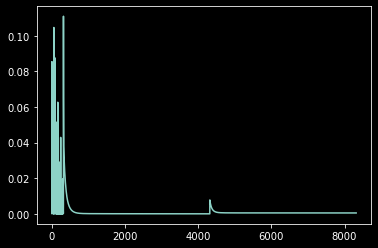

In [37]:
pastlength = 100
nn = simpleRNN(pastlength, activation=['ReLU', 'sigmoid'], lossname='MSE')
ynorm = myML.norm0to1_minmax(maxx=[4],minn=[-4]) #Bigger than the actual limits because we can't reach them with a sigmoid 
costs, tt = nn.train(t, ynorm.normalize(y), lr=0.1)
plt.plot(costs)
plt.show()

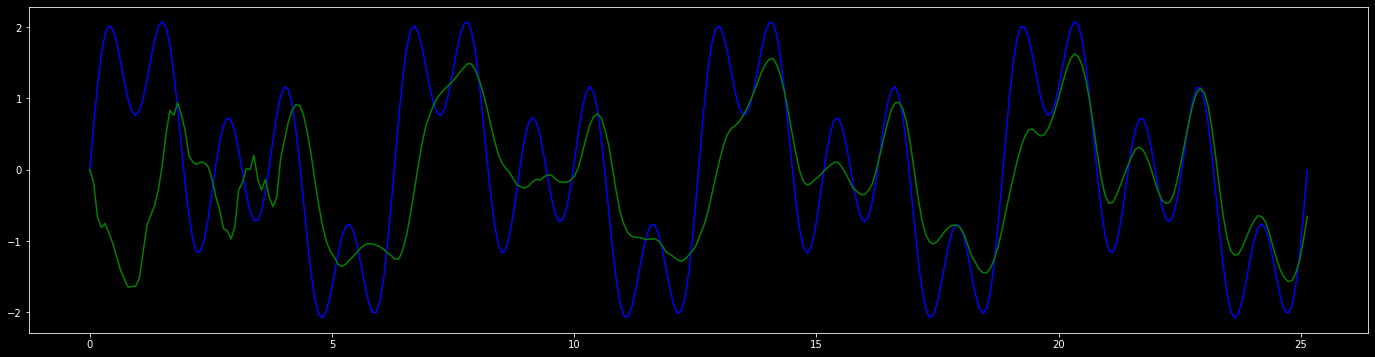

In [28]:
yplot = ynorm.recover(np.array([tt]))[0,:]
plt.style.use('dark_background')
fig = plt.figure(figsize=(24,6))
ax = plt.axes()
ax.plot(t[0,:],y[0,:], color='b')
ax.plot(t[0,:],yplot, color='g')
plt.show()

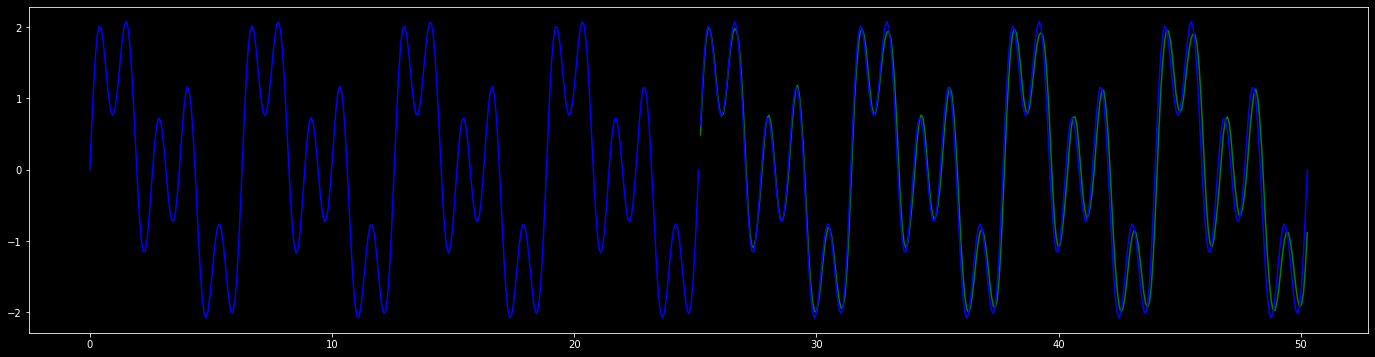

In [35]:
nn.resetstate(ynorm.normalize(y))
future = 320
time = []
yplot = np.zeros((1,future))
for i in range(future):
    yplot[0,i] = nn.advanceintime()
    time.append(t[0,-1]+timestep*(i+1))
yplot = ynorm.recover(yplot)[0,:]

plt.style.use('dark_background')
fig = plt.figure(figsize=(24,6))
ax = plt.axes()

ax.plot(time,yplot, color='g')

ax.plot(t[0,:], y[0,:], color='b')
yextra = func(np.array([time]))
ax.plot(time,yextra[0,:], color='b')
plt.show()

Frame 0out of 640
Frame 50out of 640
Frame 100out of 640
Frame 150out of 640
Frame 200out of 640
Frame 250out of 640
Frame 300out of 640
Frame 350out of 640
Frame 400out of 640
Frame 450out of 640
Frame 500out of 640
Frame 550out of 640
Frame 600out of 640


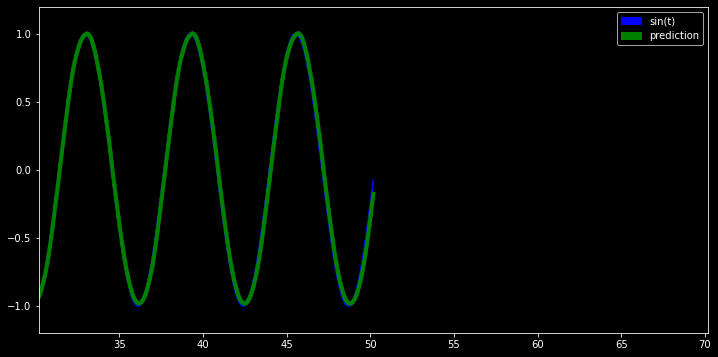

In [265]:
plt.style.use('dark_background')
fig = plt.figure(figsize=(12,6))
ax = plt.axes()

ax.set_ylim([-1.2,1.2])
legend_elements = [mpatches.Patch(color='b', label='sin(t)'),
                   mpatches.Patch(color='g', label='prediction')]
ax.legend(handles=legend_elements, loc='upper right')

k=0
for inst in range(t.shape[1]+future-1):
    if inst % 50 == 0: print('Frame '+str(inst)+'out of '+str(t.shape[1]+future))

    if inst < t.shape[1]:
        ax.plot(t[0,inst:inst+2],y[0,inst:inst+2], color='b', linewidth=2)
        ax.set_xlim([t[0,inst]-wavesize,t[0,inst]+wavesize])
    elif inst == t.shape[1]:
        ax.plot([t[0,-1], time[0]],[y[0,-1], yextra[0]], color='b', linewidth=2)
        ax.set_xlim([t[0,-1]-wavesize,t[0,-1]+wavesize])
    else:
        ax.plot(time[k:k+2],yextra[k:k+2], color='b', linewidth=2)
        ax.plot(time[k:k+2],yplot[k:k+2], color='g', linewidth=4)
        k+=1
        ax.set_xlim([time[k]-wavesize,time[k]+wavesize])
    
    plt.savefig('imgs/img{:05d}'.format(inst), dpi=300)
